In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 


import torch.nn.functional as F

## Load data

In [2]:
#/Users/laurabraadrasmussen/Documents/UNI/5. semester/Deep Learning/Projekt/Data
train_data_without = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')
train_data = pd.read_csv('../Data/training_with_aug.csv')


In [3]:
train_data = train_data.drop('Unnamed: 0', axis = 1)

In [26]:
len(test_data)

1783

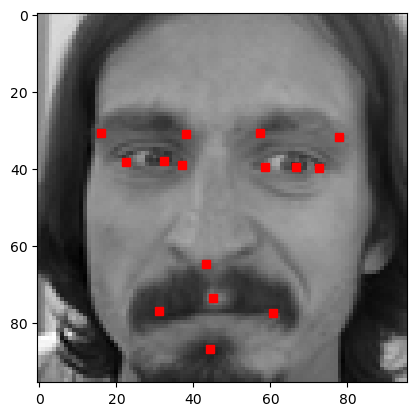

In [5]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 4)

## Data preprocessing

In [6]:
# Fjerner NA i dataset
train_data = train_data.dropna()
len(train_data)

5005

In [7]:
# 200 random samples
train_data_200 = train_data.sample(n = 1500)

In [8]:
#train_data_200[:1].left_eye_center_x

In [9]:
#train_data_200.iloc[8]


## Model

In [10]:
#make data iterator for spiral dataset

class imageDataset(Dataset):
 
  def __init__(self, file_name):
    labels=[file_name.iloc[i].values[0:30] for i in range(len(train_data_200))]
    inputs=[file_name.iloc[i].values[30:31] for i in range(len(train_data_200))]
    
    inputs = [(i[0].split()) for i in inputs]
    inputs = [[int(i) for i in j] for j in inputs] 
    inputs = [np.reshape(i, (96,96)) for i in inputs]
    inputs = [np.expand_dims(i,0) for i in inputs]
    
    
    
    #print(inputs[0])
    #print(type(inputs[1]))
    self.labels=torch.tensor(labels,dtype=torch.float32) #convert to torch floats otherwise 
    self.inputs=torch.tensor(inputs, dtype=torch.float) #we will get an error message
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]
    



In [11]:
data = imageDataset(train_data_200)

/Users/laurabraadrasmussen/opt/anaconda3/envs/slml/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/torch/csrc/utils/tensor_new.cpp:201.)


In [12]:
batch_size = 100
#Convert to tensors
x_train = data.inputs
y_train = data.labels

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

#testset = torch.utils.data.TensorDataset(x_test, y_test)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [13]:
input_shape = x_train[0].shape
print('input_shape :',input_shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : torch.Size([1, 96, 96])
x_train shape: torch.Size([1500, 1, 96, 96])
1500 train samples
y_train shape: torch.Size([1500, 30])


In [14]:
#%% make network
num_classes = 30


#something simple like cnn-cnn-fc-relu-fc will do

# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.relu
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=3,padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256,kernel_size=5)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3)
        self.bn4 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Linear(9216, 1024)
        self.FC1 = nn.Linear(1024, 256)  
        self.FC2 = nn.Linear(256, num_classes)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = F.max_pool2d(x, kernel_size=2)
    
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.bn4(x)
        
        x = x.view(x.shape[0],-1)
        
        x = self.fc1(x)

        x = self.FC1(x)
        x = self.FC2(x)
        
        return x

net = NeuralNetwork()

In [15]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#optimizer = optim.SGD(fcn.parameters(), lr=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) # decrease LR every two steps

nEpocs = 30 # How many times should we run over the data set?
totaliter = 0
net.train()
for epoch in range(nEpocs):  # loop over the dataset multiple times
    #print('epoch',epoch)
    running_loss = 0.0
    
    #scheduler.step()
    
    for i, data in enumerate(trainloader, 0):
        totaliter+=1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize      
        outputs = net(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)
        loss = criterion(outputs_reshape, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))
            
    running_loss = 0.0
print('Finished Training')
net.eval()

Epoch 1, Train loss: 114.253
Epoch 2, Train loss: 20.475
Epoch 3, Train loss: 16.672
Epoch 4, Train loss: 15.210
Epoch 5, Train loss: 14.181
Epoch 6, Train loss: 14.720
Epoch 7, Train loss: 16.291
Epoch 8, Train loss: 12.450
Epoch 9, Train loss: 10.751
Epoch 10, Train loss: 10.392
Epoch 11, Train loss: 8.878
Epoch 12, Train loss: 7.197
Epoch 13, Train loss: 5.089
Epoch 14, Train loss: 4.182
Epoch 15, Train loss: 4.025
Epoch 16, Train loss: 3.235
Epoch 17, Train loss: 3.635
Epoch 18, Train loss: 2.665
Epoch 19, Train loss: 2.042
Epoch 20, Train loss: 2.466
Epoch 21, Train loss: 2.971
Epoch 22, Train loss: 2.826
Epoch 23, Train loss: 1.769
Epoch 24, Train loss: 1.902
Epoch 25, Train loss: 1.624
Epoch 26, Train loss: 1.463
Epoch 27, Train loss: 1.765
Epoch 28, Train loss: 1.566
Epoch 29, Train loss: 1.361
Epoch 30, Train loss: 1.517
Finished Training


NeuralNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (FC1): Linear(in_features=1024, out_fea

[[69.95726013 37.55479431]
 [28.07333565 35.27100372]
 [62.07346344 37.50619507]
 [77.45143127 39.38055801]
 [34.05956268 37.02601242]
 [18.72117996 35.79068756]
 [57.88667679 29.38299751]
 [85.11143494 32.08039474]
 [37.19365311 26.54050064]
 [12.00598717 26.91245079]
 [47.64434052 56.53550339]
 [64.46537018 76.36108398]
 [29.41614914 74.76767731]
 [46.00572968 70.88349915]
 [46.04037476 84.64964294]]


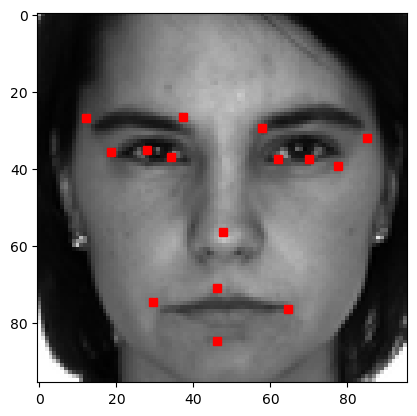

In [17]:

def get_image_and_keypoints2(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(outputs[25].tolist()).values.reshape([15, 2])
    print(keypoints)
    return image, keypoints

def get_image_and_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints2(series)


def show_image_with_keypoints2(series):
    image, keypoints = get_image_and_keypoints2(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints2(series)
    
show_image_with_keypoints_by_id2(train_data, 1533)

## Predictions

In [22]:
image_lists = [np.array(list((map(float, test_data.iloc[i, -1].split(' '))))).reshape(96, 96) for i in range(len(test_data))]

In [29]:
test_images = [np.expand_dims(i,0) for i in image_lists]
#test_outputs = [net(torch.Tensor(i)) for i in test_images]
test_outputs = [net(torch.Tensor(test_images[i]).unsqueeze(0)) for i in range(200)]

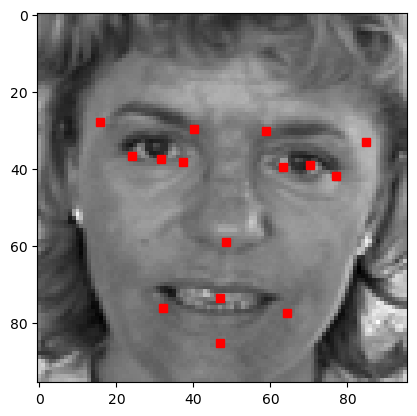

In [31]:
def get_image_and_keypoints2(series,id):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(test_outputs[id].tolist()).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    return get_image_and_keypoints2(series,id)


def show_image_with_keypoints2(series,id):
    image, keypoints = get_image_and_keypoints2(series,id)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    show_image_with_keypoints2(series,id)
    
show_image_with_keypoints_by_id2(test_data, 199)